 # <center>"Computer says no... Because: "</center>
 ***
## <center> Towards explainable AI algorithms </center>

<center>Irma Mastenbroek <br>
BSc Wiskunde en Toepassingen <br>
Utrecht University<br> 
BrainCreators</center>

## 1) Introduction

Welcome, thank you for taking an interest in my Bachelors thesis on Layerwise Relevance Propagation, a novel explainability method from 2015. In this notebook, I will talk you through my code and insights on LRP. The focus will lie on understanding, using and trusting the explainability method. We will use the MNIST database of handwritten digits, train a neural network to classify the images and use LRP to give an explanation on the classification.

## 2) Training the ANN

We will start by training a neural network to classify handwritten digits from the MNIST database. For this, we need to import Keras library for creating neural networks, the MNIST database and some metrics to evaluate our model.

In [8]:
import keras
import tensorflow as tf 
from sklearn.metrics import classification_report, confusion_matrix
mnist = keras.datasets.mnist

Now, we will divide the MNIST data into two parts: 60.000 images will be used for training the model, and 10.000 images will be used for testing. The images from the database are 28x28 pixel images with pixelvalues between 0 (black) and 255 (white). Normally, this would be rescaled to (0,1), but because LRP will by definition not assign relevance to pixels with a value of 0, we will rescale the images from -1 (black) to 1 (white). We will discuss this in greater detail later on.

In [9]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = -1 + x_train / 255.0, -1 + x_test / 255.0
x_train, x_test = 2*x_train +1, 2*x_test +1 

Our model will consist of an input layer of $28\times 28 = 784$ neurons, 3 hidden layers of 1200 neurons each, a Softmax output layer and after each hidden layer a dropout layer with rate 0.2 in order to prevent *overfitting*. We will use the Adam optimizer, and the categorical crossentropy loss function. We will then fit our model on the trainingdata, using a batch size of 500 over a total of 30 epochs. This will take a couple of minutes, so make yourself a cup of tea!

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1200, activation = tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1200, activation = tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1200, activation = tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=30, batch_size=500)
model.evaluate(x_test, y_test)
conf = confusion_matrix(y_test, model.predict_classes(x_test))
print(conf)

Epoch 1/30
60000/60000 [==============================] - 18s 306us/step - loss: 0.4307 - acc: 0.8685
Epoch 2/30
60000/60000 [==============================] - 17s 290us/step - loss: 0.1530 - acc: 0.9533
Epoch 3/30
60000/60000 [==============================] - 18s 302us/step - loss: 0.1174 - acc: 0.9640
Epoch 4/30
60000/60000 [==============================] - 18s 296us/step - loss: 0.0973 - acc: 0.9694
Epoch 5/30
60000/60000 [==============================] - 17s 286us/step - loss: 0.0905 - acc: 0.9718
Epoch 6/30
60000/60000 [==============================] - 17s 288us/step - loss: 0.0825 - acc: 0.9741
Epoch 7/30
60000/60000 [==============================] - 17s 288us/step - loss: 0.0669 - acc: 0.9786
Epoch 8/30
60000/60000 [==============================] - 17s 289us/step - loss: 0.0685 - acc: 0.9787
Epoch 9/30
60000/60000 [==============================] - 18s 304us/step - loss: 0.0559 - acc: 0.9822
Epoch 10/30
60000/60000 [==============================] - 18s 293us/step - loss: 

Once this has finished, we can see the *confusion matrix* at the bottom. In this matrix we can see all mistakes of our ANN in the test data, sorted by its class. For this neural network, a test accuracy of around 98 percent is reached. <br>
<br>
We are now going to show some wrongly predicted images by the network. We will use the matplotib.pyplot library for visualizing and the numpy library for linear algebra. First, we extract some wrongly predicted images and then will will show the first 22 images that were wrongly predicted.

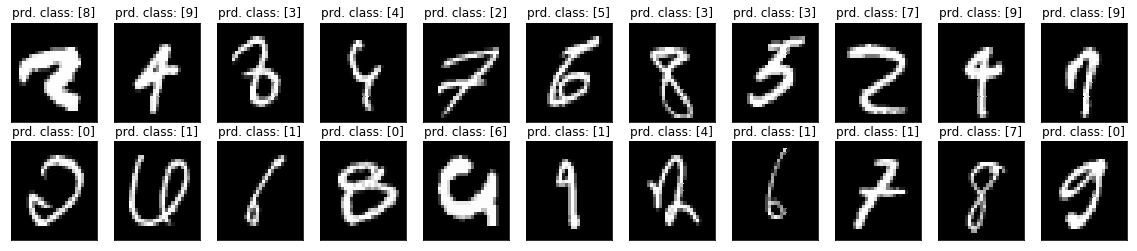

In [235]:
import matplotlib.pyplot as plt
import numpy

s = []
wrongclass = []
trueclass = []
p = model.predict_classes(x_test)
for i in range (4000):
    if p[i]!=y_test[i]:
        s.append(x_test[i])
        wrongclass.append(p[i])
        trueclass.append(y_test[i])

s = numpy.asarray(s)
wrongclass = numpy.asarray(wrongclass)
trueclass = numpy.asarray(trueclass)

startop = 50
cijfers = s[startop:startop+22]

fig,ax=plt.subplots(nrows=2, ncols=11, figsize = (20,4))

#draws digits
for row in range(2):
    for col in range(11):
        ax[row,col].pcolormesh(cijfers[row*11 + col],cmap='gray')
        ax[row,col].invert_yaxis()
        ax[row,col].set_title("prd. class: [" + str(wrongclass[startop + row*11 + col])+ "]")
        ax[row,col].yaxis.set_major_locator(plt.NullLocator())
        ax[row,col].xaxis.set_major_locator(plt.NullLocator())
plt.show()

Suppose we want to get some insight in the thinking process of this neural network, it might be useful to look at which images it fails to recognize correctly. In the figure above, we listed a random selection of images that were wrongly predicted by the model we just trained. Looking at some pictures, we could cut our network some slack: that image does look ambiguous. However, in some other pictures one might wonder why the network failed to classify it correctly. It would be useful to have an idea what the network was *looking* at. What parts of the image were important in the classification? This is where our explainability method comes in to play. 

## 3) Layerwise Relevance Propagation (LRP) - *THEORY*

In a 2015 article (Original paper: https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0130140&type=printable), a method for explaining single image classifications using Layerwise Relevance Propagation (LRP) is suggested. In this section, we will discuss their work and the mathematics supporting it.<br>
<br>
The overall idea of pixel-wise decomposition is to have some notion on how *relevant* a single input pixel $x_d$ in an image $x\in \mathbb{R}^N$ is to the prediction that the image belongs to a chosen class $c$, which is denoted by $f_c(x)>0$. We are looking for a sequence $(R_d)_{d=1}^{N}$, such that 
$$f_c(x)=\sum_{d=1}^{N}R_d. $$ 
The qualitative interpretation is that $R_d<0$ contributes evidence against the presence of a member from class $c$, while $R_d>0$ contributes evidence for its presence. As every pixel in the input space will correspond to some *relevance value* $R_d$, we are able to plot these relevances as a picture with the same dimensions as the input, creating a *heat map*. We are going to focus on *layerwise relevance propagation*, which operates by back propagating relevance through the network. <br>
<br>
LRP assigns a relevance score $R_n^{(l)}$ to each neuron $n$ in the $l$th layer of the network in such a way that the following equation holds:
\begin{equation}\label{conservation}
f_c(x)= \dots = \sum_{j\in l+1}R_j^{(l+1)} = \sum_{i\in l}R_i^{(l)} = \dots = \sum_{d=1}^N R_d^{(1)}.
\end{equation}
Relevance will be passed through the network layer for layer, and we will express this in terms of messages $R_{i\leftarrow j}^{(l,l+1)}$ between neurons $j$ and $i$ from the $l+1$th to the $l$th layer. Say our network has $L$ layers, then we define the relevances as follows:
\begin{eqnarray}
R^{(L)} &=& f_c(x)\nonumber\\
R^{(l)}_i &=& \sum\limits_{j|i\in N_j}R_{i\leftarrow j}^{(l,l+1)}, 
\end{eqnarray}
where the set $N_j$ contains all neurons that point to neuron $j$. The second line states that the relevance of a neuron is defined by the sum of all relevance it receives. Now, we only need to define the mapping $R_{i\leftarrow j}^{(l,l+1)}$ such that it redistributes the relevance without violating the conservation criterion in equation. In order to satisfy this criterion, we introduce a new constraint
\begin{equation}\label{conservationmulti}
R_j^{(l+1)}=\sum\limits_{i|i\in N_j}R_{i\leftarrow j}^{(l,l+1)},
\end{equation}
which means that all relevance neuron $j$ receives, has to be fully redistributed over all neurons in the previous layer. 
 As described in chapter 2, in an ANN, information is passed from one layer to the next one by a linear projection followed by a non-linear function:
\begin{eqnarray}
z_{ij}=&x_iw_{ij}\\
z_j=&\sum_i z_{ij}+b_j\\
x_j=&g(z_j)
\end{eqnarray}
where $x_i$ denotes the activation of the $i$th neuron, $w_{ij}$ denotes the weight between neurons $i$ and $j$, $b_j$ denotes the bias of the $j$th node and $g$ denotes some non-linear function like ReLU or the sigmoid function. A first possible choice for the relevance decomposition given in the original paper is based on the ratio of pre-activations and is given by:
\begin{equation}\label{lrpz}
R_{i\leftarrow j}^{(l,l+1)}=R_j^{(l+1)}\frac{z_{ij}}{z_j}.
\end{equation}
However, we can check that this definition violates the conservation criterion by a factor of $(1-\frac{b_j}{z_j})$:
\begin{eqnarray}
\sum_iR_{i\leftarrow j}^{(l,l+1)}&=&R_j^{(l+1)}\sum_i \frac{z_{ij}}{z_j}\nonumber\\
&=&R_j^{(l+1)} \frac{\sum_iz_{ij}+b_j -b_j}{z_j}\nonumber\\
&=&R_j^{(l+1)} \frac{z_j -b_j}{z_j}\nonumber\\
&=&R_j^{(l+1)} (1-\frac{b_j}{z_j})\nonumber\\
&\neq& R_j^{(l+1)}.\nonumber
\end{eqnarray}
In practice however, this factor will be approximately 1, which is why this spillage is mostly ignored. If necessary, the residual bias relevance can be redistributed onto each neuron $x_i$, rescaled by their received relevance. We would like to note that this is somewhat sloppy, as we now violate the only restriction defining a heatmap. The article neither gives a sufficient, nor a necessary definition of relevance. The question on what exactly *is* relevance in a mathematical or intuitive sense, remains unanswered.

## 4) Layerwise Relevance Propagation (LRP) - *IMPLEMENTATION*
In this section, we will discuss our implementation of the LRP algorithm. We back propagate our way through the layers of the network, only considering non-dropout layers. Our function is called cr (short for create relevance) and takes a $28\times28$ pixel image and a desired class, and it returns the heatmap of that image for that particular class.

In [238]:

def cr(x, ofclass):
    L = 7
    R = []
    PrevRel = numpy.zeros(10)
    PrevRel[ofclass] = 100
    
    R.append(PrevRel)

    for l in range(L-1, -1, -1):
        w_b = model.layers[l+1].get_weights()
        if (w_b == []) : 
            R.append(PrevRel)
    
        else :
            weights = w_b[0] #gewichten tussen (layer) en (layer+1)..... weights[i,j]=weight tussen i in (layer) en j in (layer + 1)
            biases = w_b[1] #biases van (layer + 1)

            getout = K.function([model.layers[0].input, K.learning_phase()],[model.layers[l].output])
            x = numpy.expand_dims(x.flatten(), axis = 0)
            outp = getout([x])[0]
            activations = outp[0] #activations van (layer)
            
            #zij = numpy.multiply(activations,numpy.transpose(weights))
            zij = numpy.transpose(numpy.multiply(numpy.float_power(activations,1.01),numpy.transpose(weights)))
            #zij = numpy.transpose(zij)
            ones = numpy.ones(weights.shape[0])
            zj = numpy.dot(ones,zij)+biases
            Rij = PrevRel*zij/zj
            ones = numpy.ones(weights.shape[1])
            Ri = numpy.dot(Rij,ones)
            R.append(Ri)
            PrevRel = Ri

    heatmap = R[L]
    heatmap = heatmap.reshape((28,28))
    return heatmap

We would like to create a heatmap with a certain colorscheme; a $28\times28$ relevance matrix doesn't look appealing. We choose for colorscheme *jet*, which is blue for negative values, green for values around zero and red for positive values. In order to get green at zero, we use a function called MidpointNormalize. 

In [236]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))


Now that we have our function for creating a relevance heatmap, and all the necessary help functions, let's create some heatmaps of the first row of wrongly predicted images from our example above.

<class 'numpy.ndarray'>
(2, 11)
(22, 28, 28)


/home/braincreator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in float_power
/home/braincreator/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2061: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


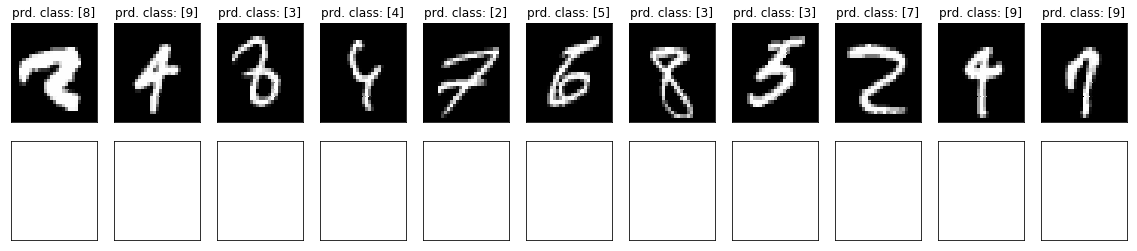

In [239]:
from keras import backend as K
import time
startop = 50
cijfers = s[startop:startop+22]

fig,ax=plt.subplots(nrows=2, ncols=11, figsize = (20,4))
print(type(ax))
print(ax.shape)
print(cijfers.shape)
for col in range(11):
    ax[0,col].pcolormesh(cijfers[col],cmap='gray')
    ax[0,col].invert_yaxis()
    ax[0,col].set_title("prd. class: [" + str(wrongclass[startop + col])+ "]")
    ax[0,col].yaxis.set_major_locator(plt.NullLocator())
    ax[0,col].xaxis.set_major_locator(plt.NullLocator())
    ax[1,col].pcolormesh(cr(cijfers[col],wrongclass[50+col]),cmap='jet', norm = MidpointNormalize(midpoint = 0))
    ax[1,col].invert_yaxis()
    ax[1,col].yaxis.set_major_locator(plt.NullLocator())
    ax[1,col].xaxis.set_major_locator(plt.NullLocator())


plt.show()


In [68]:
import time 
t0 = time.time()  # start time
#
t1 = time.time() # end time
print(t1 - t0)

0.3342254161834717


These heatmaps are created for their predicted class (which is not the true class, as all of these images were wrongly classified by our network). Take some time to interpret these heatmaps, red should mean "these pixels are relevant in making my prediction", whereas blue should mean "these pixels are bothering me for making this prediction". <br>
<br>
You were probably able to find one or more images which looked promising and logical. However, some might look a bit random: we could be wondering if these heatmaps make sense at all. Maybe they do make sense for the network, but just not for us. In this case the heatmaps are still useful, as they give insight in how our network is *thinking*. <br>
<br>
However, we haven't got a clear intuition as to why LRP should work at all. The definition of LRP simply states that something called *Relevance* should be passed on through the network using *some* rule which may depend on the neural network itself (weights, biases) and on the input image (activations in all layers). We would like to find out if these heatmaps are always meaningful. In order to quantify this, we will need to create thousands of heatmaps. Using our own algorithm above, this will take huge amounts of time. <br>
## 5) Using iNNvestigate wrapper
We are going to speed things up a bit by using the iNNvestigate wrapper for executing the LRP algorithm (available at https://github.com/albermax/innvestigate). If you are planning to work with LRP, I highly recommend using this wrapper, as it works intuitive and fast. iNNvestigate can be installed using the following commands in your terminal:

Now, we will import innvestigate into python, create an analyzer and show 10 images with heatmaps for all classes to show that it is indeed a fast algorithm.

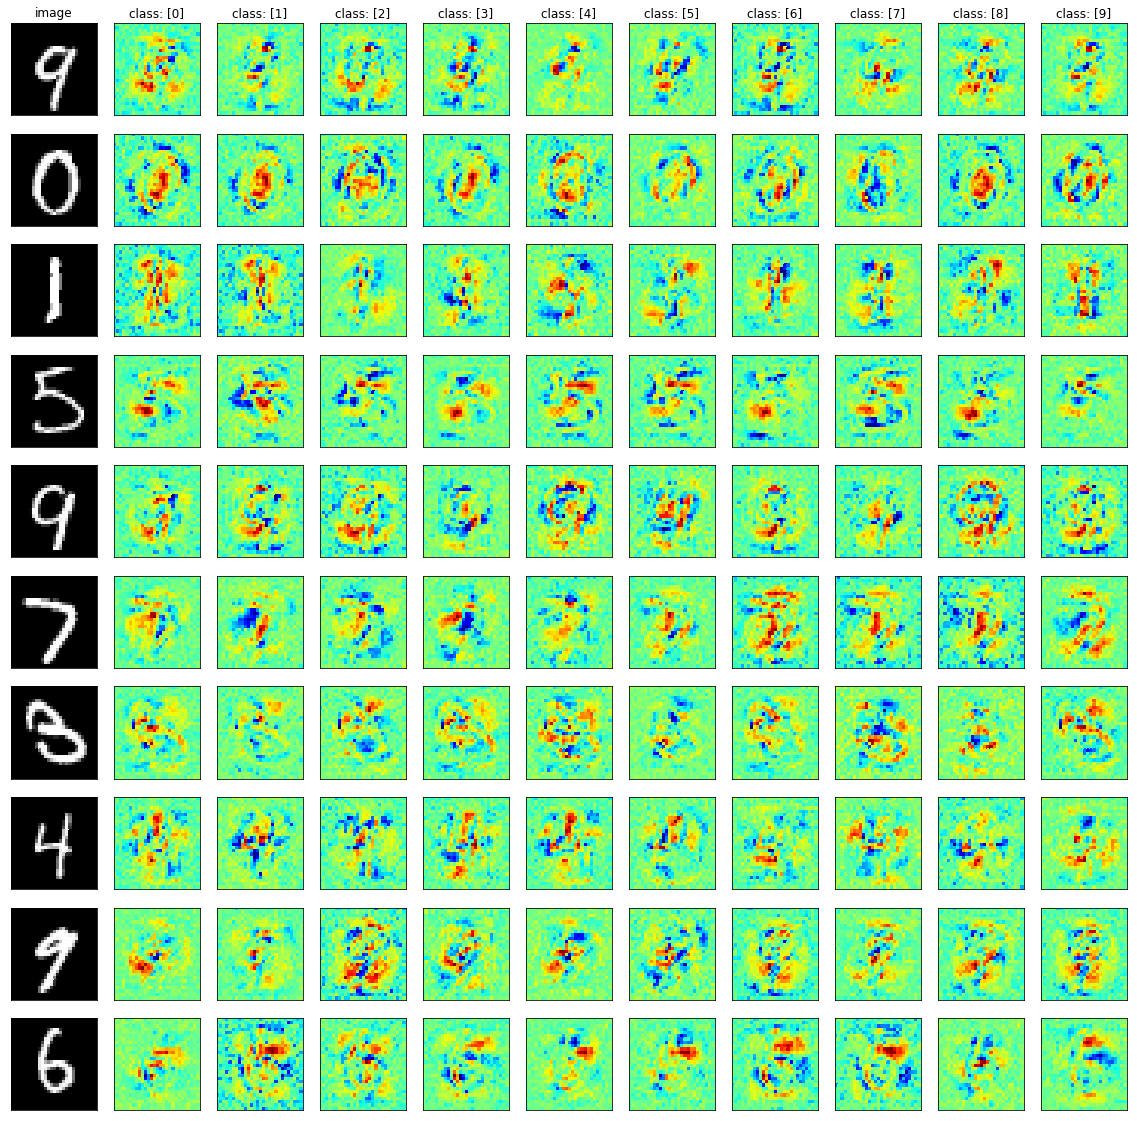

In [205]:
import innvestigate 

nrOfPics = 10
sample = x_test[12:12+nrOfPics,:,:]
method = "lrp.z"
#method = "gradient"
#method = "lrp.w_square"
analyzer = innvestigate.create_analyzer(name=method, model=model, neuron_selection_mode = "index")
analyzer.compile_analyzer()

fig,ax=plt.subplots(nrows=nrOfPics, ncols=11, figsize = (20,20))

for pic in range(nrOfPics):
    ax[pic,0].pcolormesh(sample[pic],cmap='gray')
    ax[pic,0].invert_yaxis()
    ax[pic,0].yaxis.set_major_locator(plt.NullLocator())
    ax[pic,0].xaxis.set_major_locator(plt.NullLocator())

ax[0,0].set_title("image")
for cl in range(10):
    ax[0,cl+1].set_title("class: [" + str(cl)+ "]")
    heatmaps = analyzer.analyze(sample, cl)
    for pic in range(nrOfPics):
        #rand = np.random.rand(28,28)
        #rand = rand*2 - 1 
        #ax[pic,cl+1].pcolormesh(rand,cmap='jet', norm = MidpointNormalize(midpoint = 0))
        ax[pic,cl+1].pcolormesh(heatmaps[pic],cmap='jet', norm = MidpointNormalize(midpoint = 0))
        ax[pic,cl+1].invert_yaxis()
        ax[pic,cl+1].yaxis.set_major_locator(plt.NullLocator())
        ax[pic,cl+1].xaxis.set_major_locator(plt.NullLocator())

plt.show()


Hopefully, that took about 10 seconds to load. Now, you could try and play around with LRP if that is the main goal of visiting this notebook. For a more detailed overview of usage and examples, I refer to the documentation of iNNvestigate on their github page (https://github.com/albermax/innvestigate). <br>
<br>
In the next section, we set up an experiment to test if the relevances obtained by LRP are indeed relevant for the prediction. 

## 6) Evaluating Relevance
In the previous sections we introduced an explainability method called LRP, or Layerwise Relevance Propagation, and showed its implementation. We evaluated a number of heatmaps created by our algorithm, yet we are not certain about its qualities as an explainability method. We have to ask ourselves: what makes an explanation a *good* one? What are we trying to achieve when we are explaining something? This sounds rather philosophical, but not being able to answer these questions stands in the way of quantifying the explanation generated by our method. 

In this thesis, we will only use the so called LRP-z rule as introduced in the LRP section. As we will see later on in this chapter, the resulting heatmaps are indeed meaningful when we use this pass. However, we are free to choose our own relevance pass. How would we go about that if we have no clear definition or even intuition on what makes something *relevant*? We want to take a closer look at the definition given by the researchers and find out if it restrict us from defining nonsense relevance passes. In the original paper relevance is defined only by the back propagating property. That is: we start at the output layer and assign relevance to the neuron of our desired class, which will redistribute into the previous layer. The rule used for this redistribution is free of choice, and is not restricted to additional requirements. The researchers do state that a qualitative constraint could be added: 
\begin{align}\label{extraconstraint}
\forall k: R_k, \sum_{i}z_{ik}>0 \text{ and } 0<z_{ik}<z_{i'k} \implies R_{i\leftarrow k}^{(l,l+1)}\leq R_{i'\leftarrow k}^{(l,l+1)}.
\end{align}
That is, if a node $i$ has a larger weighted activation $z_{ik}=a_iw_{ik}$, it should also receive a larger fraction of the relevance score $R_k^{(l+1)}$ of the node $k$. However, since this is not a strict inequality, we could easily define nonsense heatmaps which will nonetheless fit the definition of a relevance heatmap. An example is given by 
\begin{align}
R_{i\leftarrow j}^{(l,l+1)}=R_j^{(l+1)}/d^{(l)}
\end{align}
where $d^{(l)}$ is the number of neurons in the $l$th layer. This relevance pass will result in a heatmap with equal relevance on all pixels. It is easily shown that this relevance pass satisfies the extra constraint. However, if the inequality would have been strict, this would not be possible. The idea of adding this constraint is not pointless, and it does give an answer to the question what makes a neuron relevant: those connected with high weights to highly activated nodes.  <br>
<br>
We could now evaluate if we find this definition of relevance sufficient to trust its results. A first issue is the fact that the extra constraint only applies to positive relevances and weights. Nonetheless, even if we would extend the constraint so that it covers every possible event, the intuition stays vague. We would argue that the definition of relevance is not self explanatory enough and we therefore seek a different way of quantifying whether or not a relevance heatmap is explaining the classification in a meaningful way.
 
### 6.1) Importance
Instead of relying on the definition, we could measure the quality of a heatmap by evaluating how good it is able to point out important pixels for the classification. A pixel can be important to the prediction in two different ways: positively and negatively contributing to the prediction value. A pixel that is not important, does not have any impact on the prediction value. In order to formalize this, we define an image $x$ with the $p$th pixel flipped:
\begin{align}
x^{(p)}:= x \text{  with  } x^{(p)}_p = -x_p
\end{align}
that is, when the $p$th pixel $x_p$ is black it will be turned into a white pixel and vice versa. A downside is that gray pixels with $x_p \approx 0$ will never be important. We could solve this by treating gray pixels as white pixels, and setting their value to -1 (black) when flipped. For now we will not adapt our definition because LRP also does not assign relevance to gray pixels, which makes our definition of importance more comparable to that of relevance.\\
\\
We define the most positively important pixel $p_{imp}^{(c)}$ for predicted class $c$ in an image $x$ as follows:
\begin{align}
p_{imp}^{(c)}:=\arg\min_p \{\delta_c(x^{(p)})\}
\end{align}
where $\delta(x)$ is the output vector of our neural network when $x$ is the input. That is, the most important pixel is the one that has the greatest negative influence on the predicted value when flipped. Similarly, the most negatively important pixel $p_{-imp}^{(c)}$ is defined as
\begin{align}
p_{-imp}^{(c)}:=\arg \max_p \{\delta_c(x^{(p)})\}.
\end{align}
This can be interpreted as the pixel that was bothering us the most in making our prediction. These definitions can easily be extended to finding the $n$ most important pixels. In the next section, we will try to check how well LRP is able to point out positively and negatively important pixels.

### 6.2) Pixel flipping according to LRP
In this section, we will check if the relevance heatmaps indeed give us information on the importance of pixels. To achieve this, we will check the behaviour of pixels that were considered relevant, negatively relevant or irrelevant. Our model is trained to be very certain about a class, as uncertainty is punished more by the objective function. Because of this, a single pixel flip can make a four into a nine, instead of slowly being more and more certain that the image is a nine. To cancel out this rugged behaviour we look at all images of a certain class and average out the results over all images of that class. <br>
<br>
First, we want to create a matrix where all test images are sorted by class, such that all zero's are in the first row, all ones in the second row and so on.

In [164]:
org = [[] for x in range(10)]

for i in range(10000):
    org[y_test[i]].append(x_test[i,:,:])

for i in range (10):
    org[i] = numpy.asarray(org[i])
org = numpy.asarray(org)

Now that we have direct acces to all images of a class of our choice, we can introduce the pixelflipping algorithm. Below, my code for pixelflipping is given. This method can be used for flipping the most positively relevant, most negatively relevant and irrelevant pixels. Choose your method and the classes you want to look at, as well as by which rule you want to sort. Running this code should take a couple of minutes.

In [220]:
method = "lrp.z"
#method = "lrp.w_square"

analyzer = innvestigate.create_analyzer(name=method, model=model, neuron_selection_mode = "index")
otheranalyzer = innvestigate.create_analyzer(name=method, model=model)
analyzer.compile_analyzer()
otheranalyzer.compile_analyzer()

'''
Here, you can choose an original class and a goal class
'''
original = 3 #For our example: we want to flip fives into threes
goal = 5 #So our goal would be 3

frm = org[original] # images of all fives in the dataset
to = org[goal]

heatmaps_frm = otheranalyzer.analyze(frm)
heatmaps_to = analyzer.analyze(frm, goal)

frm_trueclass = []
to_goal = [] 
localfrm = frm.copy()

for i in range(localfrm.shape[0]): 
    '''
    Choose one of the below in order to flip positively relevant, negatively relevant or irrelevant pixels. 
    '''
    #sort = numpy.argsort(-heatmaps_frm[i].flatten()) # Use this line when you want to sort by highest relevance
    sort = numpy.argsort(heatmaps_to[i].flatten()) #Use this line when you want to sort by lowest relevance, and pixelflip from one class to another
    #sort = numpy.argsort(-abs(heatmaps_frm[i].flatten())) # Use this line when you want to sort by relevances closest to zero
    
    #d = numpy.arange(28*28)
    #numpy.random.shuffle(d)
    #turnthese = d[0:200]
    turnthese = sort[0:200]

    row_frm=numpy.zeros(41) 
    row_to=numpy.zeros(41) 
    row_frm[0] = model.predict(localfrm[i:i+1,:,:])[0][original]
    row_to[0] = model.predict(localfrm[i:i+1,:,:])[0][goal]
    
    for counter in range(40):
        for k in range(5):
            m = turnthese[counter*5+k]
            row = int(m/28)
            column = m%28
            localfrm[i,row,column] *= -1
        row_frm[counter+1] = model.predict(localfrm[i:i+1,:,:])[0][original]
        row_to[counter+1] = model.predict(localfrm[i:i+1,:,:])[0][goal]
    frm_trueclass.append(row_frm)
    to_goal.append(row_to)
        
frm_trueclass = numpy.asarray(frm_trueclass)
to_goal = numpy.asarray(to_goal)

average_frm = numpy.zeros(40)
for j in range(40):
    average_frm[j] = sum(frm_trueclass[:,j])/frm_trueclass[:,j].shape[0]
    

average_to = numpy.zeros(40)
for j in range(40):
    average_to[j] = sum(to_goal[:,j])/to_goal[:,j].shape[0]


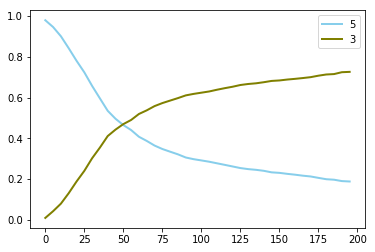

In [114]:
x=numpy.arange(0,200,5)
# multiple line plot
plt.plot(x, average_frm, marker='', color='skyblue', linewidth=2, label=original)
plt.plot(x, average_to, marker='', color='olive', linewidth=2, label = goal)
plt.legend()

In the plot above, the x-axis represents the number of flipped pixels. The blue line represents the average predicted value of the true class of the image. The green line represents the average predicted value of the so-called "goal class". In this case we are flipping a 5 into a 3, so our goal class is three. <br>
<br>
Play around with the code above. Right now we are flipping a 5 into a 3 by sorting on the negative relevance. Try to achieve the following examples:
 - 5's and 3's look somewhat similar, but can you think of two even more similar classes? How does the line chart compare to the current one?
 - Now try two classes that look nothing alike, what is the effect on the chart?
 - We are now sorting the heatmap of the goal class by negative relevance. Try sorting the heatmap of the original class by positive relevance. In this case, most relevant pixels for the prediction of the true class are flipped first. What effect does this have on the chart? Can you explain the behaviour of the goal class line?
 - Try sorting by relevances closest to zero. What will happen to the chart?

### 6.3) Some examples after flipping pixels
In the next section, we will show some examples of images that have been flipped into another class. Since we did not save our images after some number of flips, we need new function. This function will take the original class and goal class as input, as well as the prefered number of pixelflips. The function returns 10 images after pixelflipping, with corresponding prediction arrays after all pixels are flipped.

In [138]:
def flip(original, goal, nrflips):
    frm = org[original][0:10] # images of all fives in the dataset

    heatmaps_frm = otheranalyzer.analyze(frm)[0:10]
    heatmaps_to = analyzer.analyze(frm, goal)[0:10]
    localfrm = frm.copy()

    for i in range(10): 
        #sort = numpy.argsort(-heatmaps_frm[i].flatten()) ''' Use this line when you want to sort by highest relevance '''
        sort = numpy.argsort(heatmaps_to[i].flatten()) # Use this line when you want to sort by lowest relevance, and pixelflip from one class to another
        #sort = numpy.argsort(abs(heatmaps_frm[i].flatten())) ''' Use this line when you want to sort by relevances closest to zero '''
        turnthese = sort[0:nrflips]

        for k in range(nrflips):
            m = turnthese[k]
            row = int(m/28)
            column = m%28
            localfrm[i,row,column]*=-1

    predict = model.predict(localfrm)
    result = []
    result.append(localfrm)
    result.append(predict)
    return result

Now that that's out of our way, we will continue by choosing three pairs of classes which we want to show. In this example, we are looking at 4 to 9, 3 to 5 and 2 to 0. The code below will return 3 rows of 10 images after a number of pixel flips. At the top of each image we print the predicted values of the original class and the goal class after pixel flipping. 

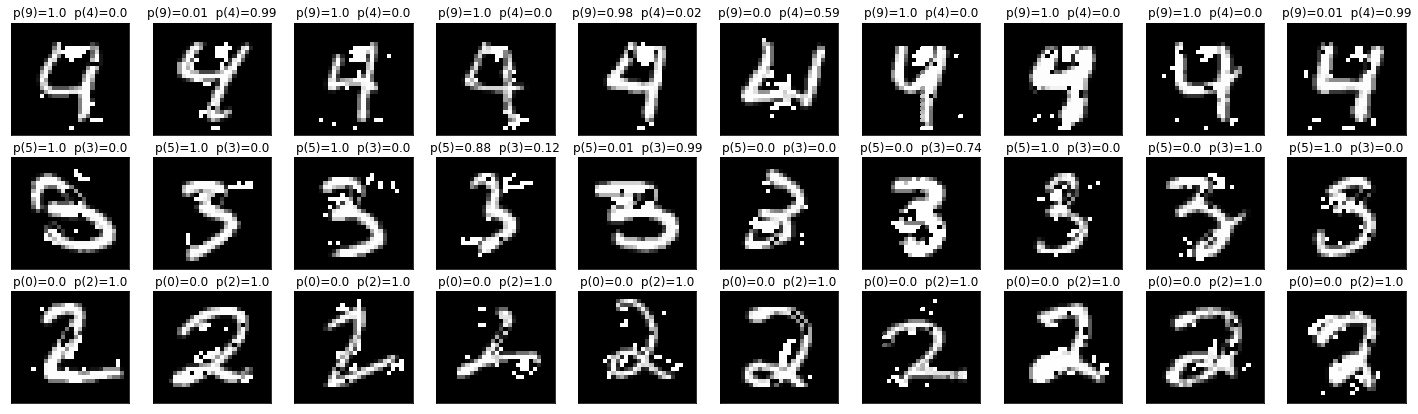

In [184]:
flips = 25
org_class = [4,3,2]
goal_class = [9,5,0]

fig,ax=plt.subplots(nrows = 3, ncols=10, figsize = (25,7))
for row in range(3):
    plaatjes = flip(org_class[row], goal_class[row], flips)[0]
    o = org_class[row]
    g = goal_class[row]
    for col in range(10):
        s = flip(o,g,flips)
        plaatje = s[0][col]
        pred_o = s[1][col][o]
        pred_g = s[1][col][g]
        ax[row,col].pcolormesh(plaatje,cmap='gray')
        ax[row,col].invert_yaxis()
        p1 = round(pred_g,2)
        p2 = round(pred_o,2)
        ax[row,col].set_title("p(" + str(g) +")=" + str(p1)+ "  p(" + str(o) +")=" + str(p2))
        ax[row,col].yaxis.set_major_locator(plt.NullLocator())
        ax[row,col].xaxis.set_major_locator(plt.NullLocator())


We found out earlier that flipping fours into nines was an easier task than flipping a two into a zero. In these images, we can see the same results. We would now like to have some functions to compare the results to. In the next section, we will introducre a method called Importance Brute Force, which will flip pixels according to the ones that are most negatively important. 

# Importance Brute Force

We will now define a method called the importance brute force. Here, we will flip pixels that make the biggest difference in the classification values. Please start by only executing this algorithm for one image instead of for all images of the goal class as it takes several minutes to flip one image. If you are interested in the results for flipping all threes into fives, I refer to my thesis. 

In [242]:
original = 2 #For our example: we want to flip twos into zeros
goal = 0 #So our goal would be 0

frm = org[original] # images of all twos in the dataset
to = org[goal]

prdmatgoal = []
prdmatfrm = []
for i in range(1):#frm.shape[0]): #start by running for just one or a couple of images, it will take a long time.
    print(i)
    img = numpy.copy(frm[i:i+1,:,:])
    rowgoal = numpy.zeros(41)
    rowfrom = numpy.zeros(41)
    rowgoal[0]=model.predict(img)[0][goal]
    rowfrom[0]=model.predict(img)[0][original]
    for counter in range(40):
        for p5 in range (5):
            prgoalmax = 0
            #prmin = 1.0
            maxrow = -1
            maxcol = -1
            for r in range(28):
                for c in range(28):
                    img[0,r,c]*=-1
                    #prfrm = model.predict(img)[0][original]
                    prgoal = model.predict(img)[0][goal]
                    if (prgoal>prgoalmax):#(prfrm<prmin):
                        prgoalmax = prgoal
                        #prmin = prfrm
                        maxrow = r
                        maxcol = c
                    img[0,r,c]*=-1
            if(maxrow==-1 and maxcol==-1):
                maxrow = randint(0,27)
                maxcol = randint(0,27)
            img[0,maxrow,maxcol] *= -1
        rowgoal[counter+1]=prgoalmax
        rowfrom[counter+1]= model.predict(img)[0][original]
    prdmatgoal.append(rowgoal)
    prdmatfrm.append(rowfrom)

prdmatfrm = numpy.asarray(prdmatfrm)
prdmatgoal = numpy.asarray(prdmatgoal)

averagefrm = numpy.zeros(41)
for j in range(41):
    averagefrm[j] = sum(prdmatfrm[:,j])/prdmatfrm[:,j].shape[0]


averagegoal = numpy.zeros(41)
for j in range(41):
    averagegoal[j] = sum(prdmatgoal[:,j])/prdmatgoal[:,j].shape[0]

0
1.0
1.0
1.0
0.9999990463256836
0.9999184608459473
0.9940357208251953
0.7314673066139221
0.2892400324344635
0.010933059267699718
0.00029312746482901275
2.9738419016211992e-06
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.4873268128212658e-07
1.4909339540736255e-07
1.414041669587246e-20
7.805496488616655e-16
6.0945883756380326e-12
1.2623002199063649e-08
5.221848368819337e-06
0.0009558116435073316


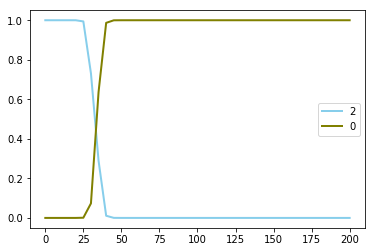

In [245]:
x=numpy.arange(0,205,5)
# multiple line plot
plt.plot(x, averagefrm, marker='', color='skyblue', linewidth=2, label=original)
plt.plot(x, averagegoal, marker='', color='olive', linewidth=2, label = goal)
plt.legend()

If one would run this code for all twos in the database, we are able to compare it to the LRP pixel flipping algorithm. In this way, we could measure the quality of LRP. 

# Conclusions 

This thesis focused on a new discipline in AI called explainable artificial intelligence (XAI), in particular a method called Layerwise Relevance Propagation (LRP) which assigns relevance to each neuron in the input layer by back propagating relevance through the network. <br>
<br>
The main goal of this thesis was to create a better understanding of relevance heatmaps of MNIST digits created by the LRP algorithm. We tried to quantify the quality of the heatmaps by looking at the impact of flipping relevant, irrelevant and negatively relevant pixels on the predicted value. Positively relevant pixels indeed appear to be important in classification, while irrelevant pixels have virtually no influence on the predicted value. When looking at negatively relevant pixels however, the influence on the predicted value of the model strongly depends on the classes we choose as original and goal class. When classes look alike, the most negatively relevant pixels indeed appear to be negatively important and are therefore meaningful. However, when the original class and goal class do not look alike, flipping the most negatively relevant pixels does not have a large effect on the predicted value of the goal class. If this is indeed the case, negatively relevant pixels are meaningless and should be ignored when interpreting the heatmap. <br>
<br>
With LRP, the rule for passing relevance is free of choice. Depending on the task one has in mind, choosing a different pass may improve results. In this thesis, we merely used pixel flipping to measure how well the LRP algorithm was performing as that made sense for MNIST images and gave quantifiable results. However, LRP can be used in many types of deep neural networks, such as convolution neural networks or text recognition networks. In many of these instances, \textit{flipping} parts of the input will not be an option. Measuring whether the output of LRP actually makes sense will have to be measured differently. A possible idea for further research would be to think of other measures to test the quality for different types of networks, which will provide more insight in what passes work best in future problems.